# Armory-Library Tutorial

### In this tutorial, we will demonstrate how to run an example in armory-library with an example model and dataset. In this tutorial we will use the mnist dataset for simplicity and a model via HuggingFace that was trained on the mnist dataset.

### The necessary imports to run an armory library example
### We install datasets because we will use it later to retrieve a dataset from the HuggingFace hub. 

In [ ]:
!pip install armory-library
!pip install datasets

### Imports for example
### These are all the necessary imports to run the example file and will all be used and explained later in the notebook

In [ ]:
import functools
import os
from pprint import pprint

from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import datasets
import mlflow
from PIL import  Image
import torch.nn
import torchmetrics.classification
import transformers

import armory.dataset
import armory.engine
import armory.export.image_classification
import armory.metrics.perturbation
import armory.model
import armory.model.image_classification
import armory.perturbation
import armory.track

### We need to get the dataset to use in this example.

In [ ]:
hf_dataset = datasets.load_dataset("mnist", split="test")

def transform(processor, sample):
    """Use the HF image processor and convert from BW To RGB"""
    sample["image"] = processor([img.convert("RGB") for img in sample["image"]])[
        "pixel_values"
    ]
    return sample

hf_processor = transformers.AutoImageProcessor.from_pretrained("farleyknight-org-username/vit-base-mnist")
hf_dataset.set_transform(functools.partial(transform, hf_processor))

image_mean = tuple(hf_processor.image_mean)
image_std = tuple(hf_processor.image_std)

image_max = (1.0-image_mean[0])/image_std[0]
image_min = (-1.0-image_mean[0])/image_std[0]

image_shape = (3, hf_processor.size['height'], hf_processor.size['width'])

labels = hf_dataset.features["label"].names
labels

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
hf_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}


For this section of code we create two variables `dataset` and `processor`.
- The `dataset` variable uses the datasets module directly from the HuggingFace API. The path location "mnist" is the location that of the same `dataset` that was used
  to train the model in this example. The parameter `split='test'` means that only the testing dataset is loading into the variable dataset. This is used because
  armory-library only using the testing dataset to test the adversarial robustness of the model.
- The `processor` variable obtains the model processor used by the model to use in our example. The is needed because the dataset needs to be in the correct form to be
  inputted into the model. The path passed into this function is a HuggingFace model card location that is the same location of the model in this example.  This function
  just obtains the `preprocessor`.



### The dataset needs to be preprocessed in the correct form for both armory-library and to be inputted into the model. A pytorch dataloader is needed to use the ART API correcly

### We need to bring in the model and attach wrappers to run in this example

In [ ]:
normalized_scale = armory.data.Scale(
    dtype=armory.data.DataType.FLOAT,
    max=image_max,
    mean=image_mean,
    std=image_std,
)

unnormalized_scale = armory.data.Scale(
    dtype=armory.data.DataType.FLOAT,
    max=image_max,
)

For this section of code we create two variables `model` and `classifier`. We found a model on HuggingFace that is trained on the same mnist dataset with the model card `farleyknight-org-username/vit-base-mnist`. This can be replaced with another model off of Huggingface or you can use a custom local model.
- The model variable uses `AutoModelForImageClassification.from_pretrained` which takes in a HuggingFace model card name as a variable. This retrieves the model from
    HuggingFace that we will use for this example. `track_params` is a function wrapper that stores the argument values as parameters in MLflow. Lastly,
    the `JaticImageClassificationModel` is another wrapper to make the model compatible with Armory. This allows the model to have a standard output like other
    JATIC image classification models.
- The `PyTorchClassifier` class wraps the model to be usable by the ART library. It is specific to image classifier models written within the PyTorch framework. It takes in as arguments the model, loss function, and optimizer. The input image sizes are the shape of all the images inside the dataset. The `channels_first` variable is true because the images in the MNIST dataset are in a channels-first (C, H, W) multi-dimensional array. The `nb_classes` describe the number of classes model predicts on. Lastly the clip value  is the values that will be the min and max values of the input after scaling.We use `track_init_params` so that the constructor parameters for the ART wrapper are also tracked in MLflow.

In [ ]:
hf_model = armory.track.track_params(
    transformers.AutoModelForImageClassification.from_pretrained)(
    pretrained_model_name_or_path="farleyknight-org-username/vit-base-mnist"
)

armory_model = armory.model.image_classification.ImageClassifier(
    name="ViT-finetuned-MNIST",
    model=hf_model,
    accessor=armory.data.Images.as_torch(scale=unnormalized_scale)
)

art_classifier = armory.track.track_init_params(PyTorchClassifier)(
    armory_model,
    loss=torch.nn.CrossEntropyLoss(),
    input_shape=image_shape,
    channels_first=True,
    nb_classes=len(labels),
    clip_values=(image_min, image_max),
)


For this section of code we transform the `dataset` and create a `dataloader`.
- To transform the `dataset` we define a function `transform` to cycle through the `dataset` and convert each image into HuggingFace 'RGB' form. The transform function is
  using the HuggingFace API where you first create a function that cycles through a `dataset` and preforms the operation on the `dataset` that is needed to get it in correct
  form. Next the `set_transform` method is used by the HuggingFace dataset which applies the transform function to the entire HuggingFace dataset.
- The `dataloader` variable is created by using the `ArmoryDataLoader` function. The `ArmoryDataloader` is a custom PyTorch DataLoader that produces numpy arrays instead of
  Tensors which is required by ART. The only inputted used in this example is the `dataset` and batch size of images. All other variable can be passed in from the PyTorch
  DataLoader API.


In [ ]:
batch_size = 16
shuffle = False

dataloader = armory.dataset.ImageClassificationDataLoader(
    hf_dataset,
    dim=armory.data.ImageDimensions.CHW,
    scale=normalized_scale,
    image_key="image",
    label_key="label",
    batch_size=batch_size,
    shuffle=shuffle,
)

evaluation_dataset = armory.evaluation.Dataset(
    name="MNIST",
    dataloader=dataloader,
)

## Next an attack is needed for armory-library that we will use to test the adversarial robustness of the machine learning model.

In [ ]:
pgd = armory.track.track_init_params(ProjectedGradientDescent)(
    art_classifier,
    batch_size=1,
    eps=8/255/image_std[0],
    eps_step=1/255/image_std[0],
    max_iter=20,
    num_random_init=1,
    random_eps=False,
    targeted=False,
    verbose=False,
)

evaluation_attack = armory.perturbation.ArtEvasionAttack(
    name="PGD",
    attack=pgd,
    use_label_for_untargeted=True,
    inputs_accessor=armory.data.Images.as_numpy(
        scale=normalized_scale
    ),
)


For this section of code we create an `attack` variable.
- The `attack` variable is create with the `ProjectedGradientDescent` class which comes from the ART library. Here is a link to the paper it was modeled after
  https://arxiv.org/abs/1706.06083. The track_init_params is used to output the initial metrics to mlflow. It takes as an input the default specs for this `attack`, but
  these can be changed to be optimized to other models and datasets.


## A method is needed now to bring together the model, dataset, and attack that will execute all the code to test the adversarial robussness of the model.

In [ ]:
perturbations = {
    "benign": [],
    "pgd": [evaluation_attack]
}

metrics = {
    "linf_norm": armory.metric.PerturbationMetric(
        armory.metrics.perturbation.PerturbationNormMetric(ord=torch.inf),
    ),
    "accuracy": armory.metric.PredictionMetric(
        torchmetrics.classification.Accuracy(task="multiclass", num_classes=len(labels)),
    ),
}

profiler = armory.metrics.compute.BasicProfiler()

sysconfig = armory.evaluation.SysConfig()

evaluation = armory.evaluation.Evaluation(
    name=f"mnist-vit-pgd",
    description=f"ViT MNIST classifier with PGD attack",
    author="TwoSix",
    dataset=evaluation_dataset,
    model=armory_model,
    perturbations=perturbations,
    metrics=metrics,
    exporter=armory.export.image_classification.ImageClassificationExporter(),
    profiler=profiler,
    sysconfig=sysconfig,
)


For this section of code we create an `evalution` variable.
- The `evalution` variable is created by `ev.Evalution` class. This variable holds all the essential elements to run an adversarial robustness attack. The elements are:
```python
    name: 'user created name of the evalution (str)'
    description: 'description of the evalution (str)'
    model: ev.Model 
    dataset: ev.Dataset
    author: 'string of the author of the evalution (str)'
    perturbations: 'dictionary of names to lists of perturbations'
    metric:  ev.Metric
```

- The `model`, `dataset`, and `attack` were created in the earlier cells. The `metric` variable is using the basic standard metric function for image classification models in
  armory-library. In the `dataset` variable, the `x_key` and `y_key` need to be properly listed for the `dataset` being used. The `x_key` needs to be the column name of the image
  in the `dataset`. The `y_key` needs to be the column name of the label in the `dataset`.


### Some final detials are needed to output metrics to mlflow and the an engine class is needed to run the evalution class.

In [ ]:
export_every_n_batches = 5
num_batches = 5

engine = armory.engine.EvaluationEngine(
    evaluation,
    export_every_n_batches=export_every_n_batches,
    limit_test_batches=num_batches,
)

INFO: GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
/Users/etienne.deprit/Projects/JATIC/armory-library/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



For this section of code we create a `task` and `engine`:
- The task tells ART the type of model the attack is running on. Armory-library currently has two tasks image classification and object detection. It takes the `evalution`
  variable, number of classes in the model, export adapter, and `export_every_n_batches`. The `export_every_n_batches` variable is the amount of batches that get exported to mlFlow, so if
  10 is selected then every 10 batches are outputted on mlFlow. The adapter takes in the Unnormalize variable which preforms the inverse of the PyTorch Normalize function. This
  operation allows the normalize dataset to be reversed to allow the unnormalized data to be displayed in mlflow.
- The `engine` variable is created from the `Evaluation` Engine which takes the task and `limit_test_batches` as variables. The `limit_test_batches` is the amount of batches of testing
  data that the engine will create metrics for. The `Evaluation` Engine only has one method `.run()` which runs the experiment.


#### Lastly, the engine variable executes .run() which runs the experiment. Function pprint is used to print the output of the run in a better format than regular python print.

In [ ]:
pprint(engine.run())

2024/03/05 11:03:16 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/03/05 11:03:16 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/Users/etienne.deprit/Projects/JATIC/armory-library/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]


Evaluating pgd: 100%|██████████| 2/2 [01:05<00:00, 38.62s/it]
                                                             
Evaluating pgd: 100%|██████████| 2/2 [01:07<00:00, 39.84s/it]
                                                             
Evaluating pgd: 100%|██████████| 2/2 [01:07<00:00, 39.86s/it]
                                                             
Evaluating pgd: 100%|██████████| 2/2 [01:08<00:00, 40.09s/it]
                                                             
Evaluating pgd:  50%|█████     | 1/2 [00:00<00:00,  1.24it/s]   2024/03/05 11:08:55 WARNING mlflow.tracking.client: Out-of-range values are detected. Clipping array (dtype: 'float32') to [0, 1]
2024/03/05 11:08:55 WARNING mlflow.tracking.client: Out-of-range values are detected. Clipping array (dtype: 'float32') to [0, 1]
2024/03/05 11:08:55 WARNING mlflow.tracking.client: Out-of-range values are detected. Clipping array (dtype: 'float32') to [0, 1]
2024/03/05 11:08:55 WARNING mlflow.tracking.clien

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      benign/accuracy      │            1.0            │
│     benign/linf_norm      │            0.0            │
│       pgd/accuracy        │            0.0            │
│       pgd/linf_norm       │     0.062745101749897     │
└───────────────────────────┴───────────────────────────┘

2024/03/05 11:08:55 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/05 11:08:55 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


{'compute': {'Avg. CPU time (s) for 5 executions of benign/perturbation': 5.497997335623949e-07,
             'Avg. CPU time (s) for 5 executions of benign/predict': 0.6795258751983055,
             'Avg. CPU time (s) for 5 executions of pgd/perturbation': 66.4395215664008,
             'Avg. CPU time (s) for 5 executions of pgd/perturbation/PGD': 66.43951569159908,
             'Avg. CPU time (s) for 5 executions of pgd/predict': 0.6548692082003982},
 'metrics': {'benign/accuracy': tensor(1.),
             'benign/linf_norm': tensor(0.),
             'pgd/accuracy': tensor(0.),
             'pgd/linf_norm': tensor(0.0627)}}


In [ ]:
#Simple script to retrieve 1 example of a benign and attacked image from the mlflow artifacts
mlflow_var = mlflow.search_experiments(filter_string=f"name = '{evaluation.name}'")[0]
path = os.path.join(
    mlflow_var.artifact_location[7:],
    engine.run_id,
    'artifacts')
image_bin, image_adv = None, None
for f in os.listdir(path):
    if f.endswith("batch_4_ex_0_pgd.png"):
        image_adv = Image.open(os.path.join(path, f))
    elif f.endswith("batch_4_ex_0_benign.png"):
        image_bin = Image.open(os.path.join(path, f))


## Benign Image

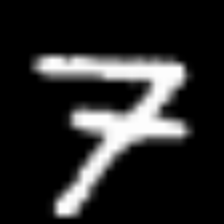

In [ ]:
image_bin

## Attacked Image

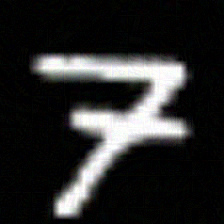

In [ ]:
image_adv

In [ ]:
type(image_adv)

PIL.PngImagePlugin.PngImageFile